In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


In [ ]:
%load_ext cudf.pandas

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

VER=1

In [5]:
train = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
print("Train shape", train.shape )
train.head()

Train shape (300000, 11)


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [6]:
train2 = pd.read_csv("/kaggle/input/playground-series-s5e2/training_extra.csv")
print("Extra Train shape", train2.shape )
train2.head()

Extra Train shape (3694318, 11)


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
1,500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
2,500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
3,500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
4,500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461


In [7]:
train = pd.concat([train,train2],axis=0,ignore_index=True)
print("Combined Train shape", train.shape)

Combined Train shape (3994318, 11)


In [8]:
test = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")
print("Test shape", test.shape )
test.head()

Test shape (200000, 10)


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [9]:
CATS = list(train.columns[1:-2])
print(f"There are {len(CATS)} categorical columns:")
print( CATS )
print(f"There are 1 numerical column:")
print( ["Weight Capacity (kg)"] )

There are 8 categorical columns:
['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
There are 1 numerical column:
['Weight Capacity (kg)']


In [10]:
COMBO = []
for i,c in enumerate(CATS):
    #print(f"{c}, ",end="")
    combine = pd.concat([train[c],test[c]],axis=0)
    combine,_ = pd.factorize(combine)
    train[c] = combine[:len(train)]
    test[c] = combine[len(train):]
    n = f"{c}_wc"
    train[n] = train[c]*100 + train["Weight Capacity (kg)"]
    test[n] = test[c]*100 + test["Weight Capacity (kg)"]
    COMBO.append(n)
print()
print(f"We engineer {len(COMBO)} new columns!")
print( COMBO )


We engineer 8 new columns!
['Brand_wc', 'Material_wc', 'Size_wc', 'Compartments_wc', 'Laptop Compartment_wc', 'Waterproof_wc', 'Style_wc', 'Color_wc']


In [11]:
FEATURES = CATS + ["Weight Capacity (kg)"] + COMBO
print(f"We now have {len(FEATURES)} columns:")
print( FEATURES )

We now have 17 columns:
['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Brand_wc', 'Material_wc', 'Size_wc', 'Compartments_wc', 'Laptop Compartment_wc', 'Waterproof_wc', 'Style_wc', 'Color_wc']


In [12]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import xgboost as xgb
print(f"XGBoost version",xgb.__version__)

XGBoost version 2.0.3


In [13]:
# STATISTICS TO AGGEGATE FOR OUR FEATURE GROUPS
STATS = ["mean","std","count","nunique","median","min","max","skew"]
STATS2 = ["mean","std"]

In [14]:
%%time

FOLDS = 7
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros((len(train)))
pred = np.zeros((len(test)))

# OUTER K FOLD
for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(f"### OUTER Fold {i+1} ###")

    X_train = train.loc[train_index,FEATURES+['Price']].reset_index(drop=True).copy()
    y_train = train.loc[train_index,'Price']

    X_valid = train.loc[test_index,FEATURES].reset_index(drop=True).copy()
    y_valid = train.loc[test_index,'Price']

    X_test = test[FEATURES].reset_index(drop=True).copy()

    # INNER K FOLD (TO PREVENT LEAKAGE WHEN USING PRICE)
    kf2 = KFold(n_splits=FOLDS, shuffle=True, random_state=42)   
    for j, (train_index2, test_index2) in enumerate(kf2.split(X_train)):
        print(f" ## INNER Fold {j+1} (outer fold {i+1}) ##")

        X_train2 = X_train.loc[train_index2,FEATURES+['Price']].copy()
        X_valid2 = X_train.loc[test_index2,FEATURES].copy()

        ### FEATURE SET 1 (uses price) ###
        col = "Weight Capacity (kg)"
        tmp = X_train2.groupby(col).Price.agg(STATS)
        tmp.columns = [f"TE1_wc_{s}" for s in STATS]
        X_valid2 = X_valid2.merge(tmp, on=col, how="left")
        for c in tmp.columns:
            X_train.loc[test_index2,c] = X_valid2[c].values

        ### FEATURE SET 2 (uses price) ###
        for col in COMBO:
            tmp = X_train2.groupby(col).Price.agg(STATS2)
            tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
            X_valid2 = X_valid2.merge(tmp, on=col, how="left")
            for c in tmp.columns:
                X_train.loc[test_index2,c] = X_valid2[c].values

    ### FEATURE SET 1 (uses price) ###
    col = "Weight Capacity (kg)"
    tmp = X_train.groupby(col).Price.agg(STATS)
    tmp.columns = [f"TE1_wc_{s}" for s in STATS]
    X_valid = X_valid.merge(tmp, on=col, how="left")
    X_test = X_test.merge(tmp, on=col, how="left")

    ### FEATURE SET 2 (uses price) ###
    for col in COMBO:
        tmp = X_train.groupby(col).Price.agg(STATS2)
        tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
        X_valid = X_valid.merge(tmp, on=col, how="left")
        X_test = X_test.merge(tmp, on=col, how="left")

    ### FEATURE SET 3 (does not use price) ###
    for col in CATS:
        col2 = "Weight Capacity (kg)"
        tmp = X_train.groupby(col)[col2].agg(STATS2)
        tmp.columns = [f"FE3_{col}_wc_{s}" for s in STATS2]
        X_train = X_train.merge(tmp, on=col, how="left")
        X_valid = X_valid.merge(tmp, on=col, how="left")
        X_test = X_test.merge(tmp, on=col, how="left")

    # CONVERT TO CATS SO XGBOOST RECOGNIZES THEM
    X_train[CATS] = X_train[CATS].astype("category")
    X_valid[CATS] = X_valid[CATS].astype("category")
    X_test[CATS] = X_test[CATS].astype("category")

    # DROP PRICE THAT WAS USED FOR TARGET ENCODING
    X_train = X_train.drop(['Price'],axis=1)

    # BUILD MODEL
    model = XGBRegressor(
        device="cuda",
        max_depth=6,  
        colsample_bytree=0.5, 
        subsample=0.8,  
        n_estimators=10_000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=10,
        early_stopping_rounds=100,
    )
    
    # TRAIN MODEL
    COLS = X_train.columns
    model.fit(
        X_train[COLS], y_train,
        eval_set=[(X_valid[COLS], y_valid)],  
        verbose=300,
    )

    # PREDICT OOF AND TEST
    oof[test_index] = model.predict(X_valid[COLS])
    pred += model.predict(X_test[COLS])

pred /= FOLDS

### OUTER Fold 1 ###
 ## INNER Fold 1 (outer fold 1) ##
 ## INNER Fold 2 (outer fold 1) ##
 ## INNER Fold 3 (outer fold 1) ##
 ## INNER Fold 4 (outer fold 1) ##
 ## INNER Fold 5 (outer fold 1) ##
 ## INNER Fold 6 (outer fold 1) ##
 ## INNER Fold 7 (outer fold 1) ##
[0]	validation_0-rmse:38.90007
[300]	validation_0-rmse:38.63344
[600]	validation_0-rmse:38.62726
[900]	validation_0-rmse:38.62562
[1200]	validation_0-rmse:38.62515
[1410]	validation_0-rmse:38.62510


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:24:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


### OUTER Fold 2 ###
 ## INNER Fold 1 (outer fold 2) ##
 ## INNER Fold 2 (outer fold 2) ##
 ## INNER Fold 3 (outer fold 2) ##
 ## INNER Fold 4 (outer fold 2) ##
 ## INNER Fold 5 (outer fold 2) ##
 ## INNER Fold 6 (outer fold 2) ##
 ## INNER Fold 7 (outer fold 2) ##
[0]	validation_0-rmse:38.89644
[300]	validation_0-rmse:38.63530
[600]	validation_0-rmse:38.62895
[900]	validation_0-rmse:38.62771
[1200]	validation_0-rmse:38.62737
[1217]	validation_0-rmse:38.62742
### OUTER Fold 3 ###
 ## INNER Fold 1 (outer fold 3) ##
 ## INNER Fold 2 (outer fold 3) ##
 ## INNER Fold 3 (outer fold 3) ##
 ## INNER Fold 4 (outer fold 3) ##
 ## INNER Fold 5 (outer fold 3) ##
 ## INNER Fold 6 (outer fold 3) ##
 ## INNER Fold 7 (outer fold 3) ##
[0]	validation_0-rmse:38.91588
[300]	validation_0-rmse:38.64178
[600]	validation_0-rmse:38.63637
[900]	validation_0-rmse:38.63504
[1200]	validation_0-rmse:38.63454
[1255]	validation_0-rmse:38.63461
### OUTER Fold 4 ###
 ## INNER Fold 1 (outer fold 4) ##
 ## INNER Fold 2

In [15]:
# COMPUTE OVERALL CV SCORE
true = train.Price.values
s = np.sqrt(np.mean( (oof-true)**2.0 ) )
print(f"=> Overall CV Score = {s}")

=> Overall CV Score = 38.65364335442265


In [17]:
#VER=1

In [18]:
# SAVE OOF TO DISK FOR ENSEMBLES
np.save(f"oof_v{VER}",oof)
print("Saved oof to disk")

Saved oof to disk


In [19]:
print(f"\nIn total, we used {len(COLS)} features, Wow!\n")
print( list(COLS) )


In total, we used 57 features, Wow!

['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Brand_wc', 'Material_wc', 'Size_wc', 'Compartments_wc', 'Laptop Compartment_wc', 'Waterproof_wc', 'Style_wc', 'Color_wc', 'TE1_wc_mean', 'TE1_wc_std', 'TE1_wc_count', 'TE1_wc_nunique', 'TE1_wc_median', 'TE1_wc_min', 'TE1_wc_max', 'TE1_wc_skew', 'TE2_Brand_wc_mean', 'TE2_Brand_wc_std', 'TE2_Material_wc_mean', 'TE2_Material_wc_std', 'TE2_Size_wc_mean', 'TE2_Size_wc_std', 'TE2_Compartments_wc_mean', 'TE2_Compartments_wc_std', 'TE2_Laptop Compartment_wc_mean', 'TE2_Laptop Compartment_wc_std', 'TE2_Waterproof_wc_mean', 'TE2_Waterproof_wc_std', 'TE2_Style_wc_mean', 'TE2_Style_wc_std', 'TE2_Color_wc_mean', 'TE2_Color_wc_std', 'FE3_Brand_wc_mean', 'FE3_Brand_wc_std', 'FE3_Material_wc_mean', 'FE3_Material_wc_std', 'FE3_Size_wc_mean', 'FE3_Size_wc_std', 'FE3_Compartments_wc_mean', 'FE3_Compartments_wc_std', 'FE3_Laptop Compartment_wc_m

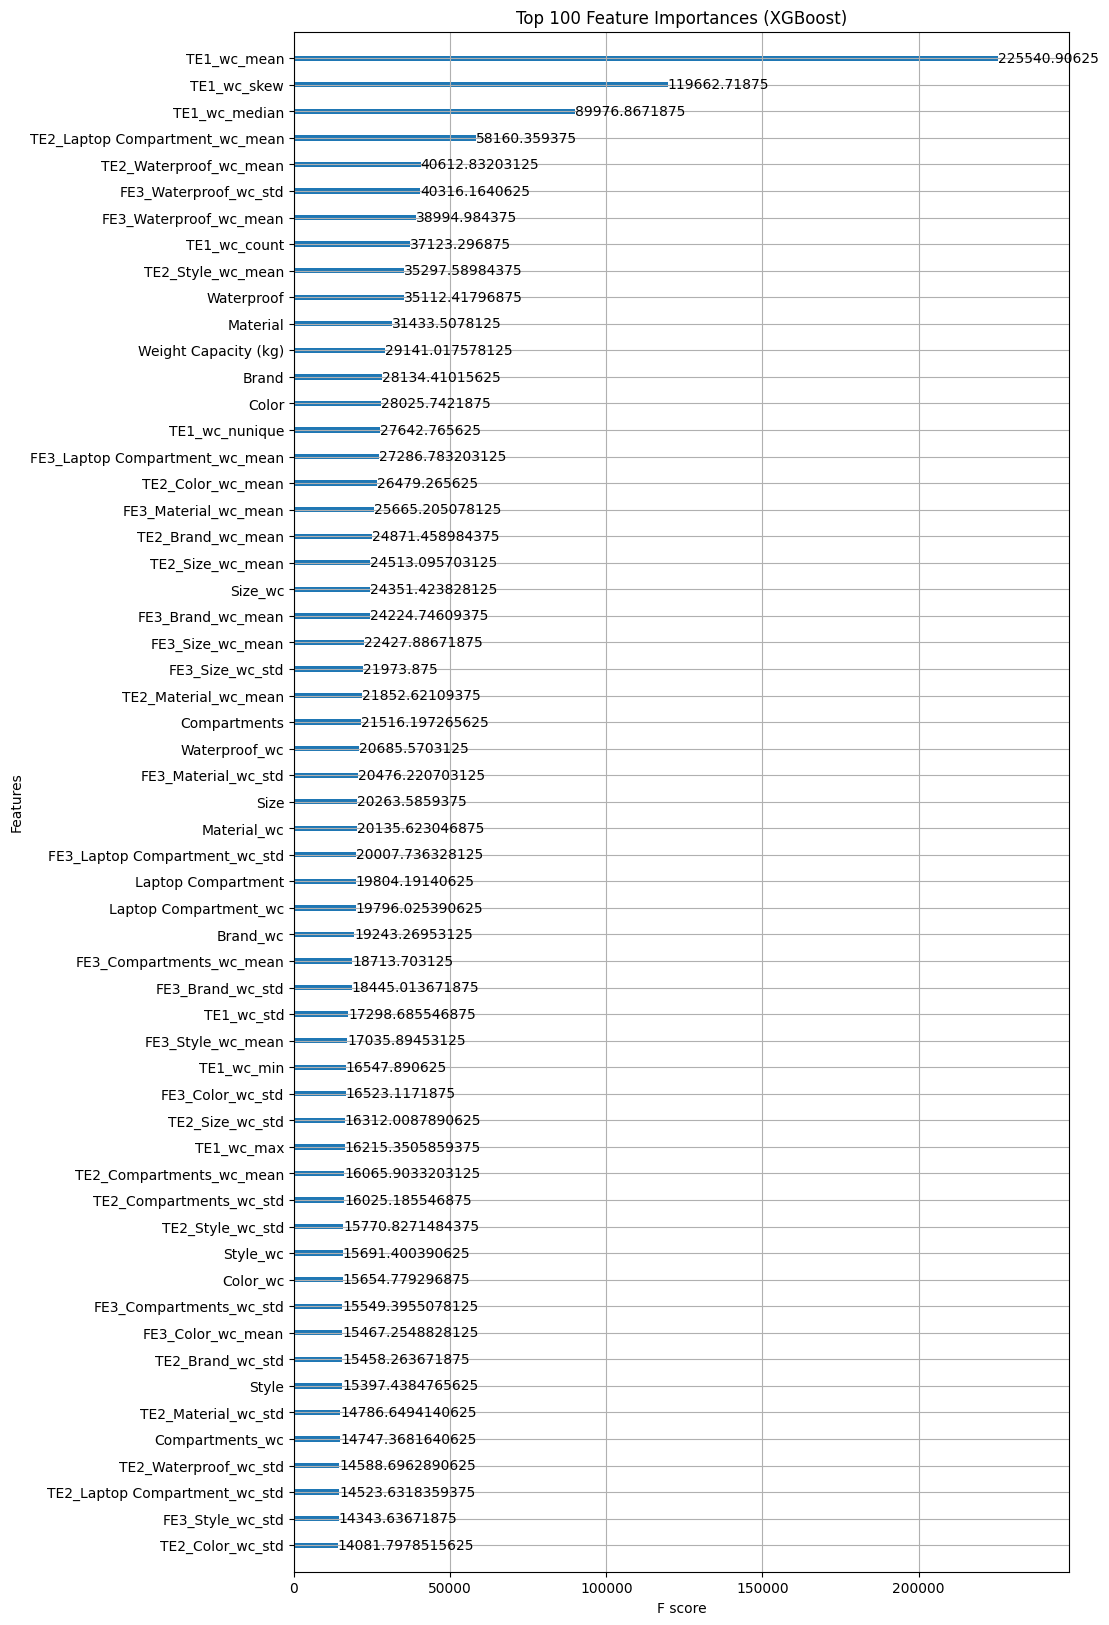

In [21]:
import xgboost as xgb
#import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(model, max_num_features=100, importance_type='gain',ax=ax)
plt.title("Top 100 Feature Importances (XGBoost)")
plt.show()

In [22]:
sub = pd.read_csv("/kaggle/input/playground-series-s5e2/sample_submission.csv")
sub.Price = pred
sub.to_csv(f"submission_v{VER}.csv",index=False)
sub.head()

,id,Price
0,300000,79.960711
1,300001,83.188800
2,300002,86.487014
3,300003,76.971987
4,300004,79.378568


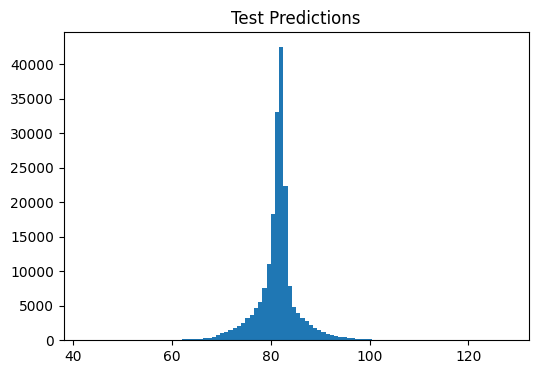

In [23]:
plt.figure(figsize=(6,4))
plt.hist(sub.Price,bins=100)
plt.title("Test Predictions")
plt.show()